<a name = "content"> </a>
# Лабораторная работа №2

### Учебная группа: М8О-409Б-18
## Рябыкин Алексей

----

## Оглавление:

----

### [1. Задание и вариант](#step1)

### [2. Подготовительная часть](#step2)

### [3. Аналитическое решение](#step3)

### [4. Явная конечно-разностная схема крест](#step4)

* [Теория](#step4.1)

* [Программная реализация](#step4.2)

* [Исследовательская часть](#step4.3)

### [5. Неявная конечно-разностная схема](#step5)

* [Теория](#step5.1)

* [Программная реализация](#step5.2)

* [Исследовательская часть](#step5.3)


<a name = 'step1'></a>
## Задание

[К оглавлению](#content)

Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.

### Вариант 7

Начально-краевая задача для дифференциального уравнения гиперболического типа:
$$\begin{aligned}
& \frac{\partial^2 u}{\partial t^2} + 2 \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + 2\frac{\partial u}{\partial x} - 3u\\
&u_x(0,t) = \exp(-t)\cos(2t)\\
&u_x(\frac{\pi}{2},t) = 0\\
&u(x,0) = \exp(-x)\cos x\\
&u_t(x,0) = -\exp(-x)\cos x
\end{aligned}$$

 Аналитическое решение: $U(x,t) = \exp(-t-x)\cos x\cos(2t)$

<a name = "step2"></a>
## Подготовительная часть
[К оглавлению](#content)

In [60]:
import math
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import time
co = 0

In [90]:
def analytic(x,t):
    return math.exp(-t-x)*math.cos(x)*math.cos(2*t)
def f_1(x,t):
    return math.exp(-t)*math.cos(2*t)
def f_2(x,t):
    return 0
def psi(x,t = None):
    return math.exp(-x)*math.cos(x)
def ksi(x,t = None):
    return -psi(x,t)
        
def MSE(x,t,u):
    error = 0
    for x_ in range(0,len(x)):
        for t_ in range(0,len(t)):
            error += (u[t_][x_] - analytic(x[x_],t[t_]))**2
    return (error/(len(x)*len(t)))/(len(x)*len(t))
    

def normm(x,t,u):
    errors = []
    for i in range(len(u)):
        maximum = 0
        for j in range(len(x)):
            tmp = abs(u[i][j] - analytic(x[j], t[i]))
            if maximum < tmp:
                maximum = tmp
        errors.append(maximum)
    return errors


def save_plot(fig):
  global co
  fig.write_html("plots2/plot" + str(co)+".html")
  co += 1
  print("plot " + str(co) + " saved")


def plot_approximations(u_approx, x):
    approximations = ['2d1', '2d2', '3d2']
    for j in range(len(u_approx)):
        fig = go.Figure()
        fig.update_layout(title = approximations[j][0] + " points " +\
                          approximations[j][-1] + \
                          ("-st order" if approximations[j][-1] == '1' else "-nd order")  +\
                          " approximation",
                         xaxis_title = 'x',
                         yaxis_title = 'U(x,t)', 
                         template = 'plotly_dark')
        for i in range(len(u_approx[j])):
            fig.add_trace(go.Scatter(x = x, y = u_approx[j][i], name = 't = ' + str(i)))
        fig.show()    
        #save_plot(fig)
        
def time_error(x,u,T):
    error = []
    for t in range(len(T)):
        error_tmp = 0
        for i in range(len(x)):
            error_tmp += (u[t][i] - analytic(x[i],T[t]))**2
        #error.append(np.sqrt(error_tmp))
        error.append(error_tmp / len(T))
    return error

def different_time(method,K,N,Tend,approx_f = 'so', approx_type = None,len = 50):
    u = []
    time_step_local = []
    space_step = math.pi/(N-1)
    for K_ in range(K,K+len):
        time_step_local.append(Tend/(K_-1))
        u.append(method(N, K_, approx_f = approx_f)[0])
    return u, time_step_local

def different_h(method, K, N,T, approx_f = 'so', approx_type = None, len = 30, a = 1, b = 2, c = -3):
    global co
    u = []
    X = []
    space_steps_local = []
    for N_ in range(N, 100):
        sigma_tmp = T/(K-1)/(math.pi/(N_ - 1))**2
        if sigma_tmp >= 1:
            print("\033[33m {}" .format('Attention!!! Stable condition:'))
            print('sigma > 1: ', sigma_tmp)
        space_steps_local.append(math.pi/(N_-1))
        X.append([0 + math.pi/2/(N-1)*i for i in range(N)])
        u.append(method(N_, K = K, approx_f = approx_f, approx_type = approx_type, a_ = a, b_ = b, c_ = c)[0])
    return u, space_steps_local, X, 

def space_error(x, u, T):
    error = []
    for x_ in range(len(x)):
        error_tmp = 0
        for t in range(len(T)):
            error_tmp += (u[t][x_] - analytic(x[x_], T[t]))**2
        error.append(error_tmp/len(x))
    return error


def different_space_errors(method, N, K, T, x0 = 0, xl = math.pi, approx_f = 'so',length = 10):
    errors = []
    h = (x0-xl)/(N-1)
    tau = T/(K-1)
    for N_ in range(N,N+length):
        space_step_local = (xl-x0)/(N_-1)
        time_step_local = T/(10*N_)
        x_local = [0 + space_step_local*i for i in range(N_)]
        t_local = [0 + time_step_local * i for i in range(10*N_)]
        #для условия стабильности схемы K = 10*N_
        error = space_error(x_local,method(N = N_, K = 10*N_, T = T, approx_f = approx_f)[0],t_local)
        errors.append(error)
    return errors

def different_time_errors(u, K, N, T, x, t, a = 1, b = 2, c = -3, len = 25):
    time_errors = []
    time_steps_local = []
    for u_, K_ in zip(u, range(K, K+len)):
        time_steps_local.append(T/(K_-1))
        t_local = np.arange(0, T + time_steps_local[-1] - 0.01, time_steps_local[-1])
        time_errors.append(time_error(x,u_,t_local))
    return time_errors

def construct_3d_plot(method, method_name):
    approx_e, X_e, T_e = method(approx_type = '2d2')
    z_plot = []
    for j in range(0, len(X_e), 1):
        tmp = []
        for i in range(0, len(X_e[j]), 1):
            tmp.append(analytic(X_e[j][i], T_e[j][i]))
        z_plot.append(tmp)
    line_marker = dict(color='#0066FF', width=2)
    lines = []
    lines.append(go.Scatter3d(x=X_e[0], y=T_e[0], z=approx_e[0], mode='lines', line=line_marker, name = method_name + ' method', legendgroup=1))
    for i, j, k in zip(X_e[1:], T_e[1:], approx_e[1:]):
        lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    line_marker = dict(color='#ff0000', width=2)
    #my_layout = go.Layout({"title": "Views by publisher", scene = go.Scene(),
    #                       "showlegend": False})
    fig_new = go.Figure(data = lines)
    fig_new.update_layout(title = 'Comparison 3d',template="plotly_dark")
    fig_new.update_scenes(xaxis_title=dict(text = 'x'), yaxis_title = dict(text = 't'), zaxis_title = dict(text = "U(x,t)"))
    fig_new.add_trace(go.Scatter3d(x=X_e[0], y=T_e[0], z=z_plot[0], mode='lines', line=line_marker, name = 'Analytic', legendgroup = 2))
    for i, j, k in zip(X_e[1:], T_e[1:], z_plot[1:]):
        fig_new.add_trace(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    fig_new.show()
    #save_plot(fig_new)

    print("Total error = ", norm_error(X_e, T_e, approx_e))
    
    
def different_time_error(method, N, T, approx_type, approx_f):
  Ks = [100, 200, 500, 1000, 5000]
  h = math.pi/N
  x = np.arange(0, math.pi + h/2 - 1e-4, h)
  taus, errors = [], []
  for K_ in Ks:
    taus.append(T/K_)
    t = np.arange(0, T + taus[-1]/2 - 1e-4, taus[-1])
    u_method = method(N = N, K = K_, T = T, approx_type = approx_type, approx_f = approx_f)[0]
    errors.append(math.log(MSE(x,t,u_method)+1e-14))
  return errors, taus


def different_space_error(method, K, T, approx_type, approx_f):
  Ns = [3, 5, 10, 25, 50, 100]
  tau = T/K
  t = np.arange(0, T + tau - 1e-4, tau)
  hs, errors = [], []
  for N_ in Ns:
    hs.append(math.pi/N_)
    x = np.arange(0, math.pi + hs[-1] - 1e-4, hs[-1])
    u_method = method(N = N_, K = K, T = T, approx_type = approx_type, approx_f = approx_f)[0]
    errors.append(math.log(MSE(x,t,u_method) + 1e-14))
  return errors, hs


def plot_different_splits(errors, xs, title, xaxis_title):
    fig = plt.figure(figsize=(20, 10))
    plt.xlabel(xaxis_title)
    plt.ylabel('Error')
    plt.title(title)
    plt.plot(xs, errors, color = 'red')

In [62]:
def plot_error(errors, type):
    e_tmp = []
    e_x = []
    for e_ in errors:
        e_x.append(len(e_))
        e_tmp.append(sum(e_)/len(e_))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = e_x, y = e_tmp))
    fig.update_layout(title = 'Errors with different ' + str(type),
                     xaxis_title = "splits", 
                     yaxis_title = "Error", 
                     template = 'plotly_dark')
    #save_plot(fig)
    fig.show()
    

In [63]:
def fill(space_step, N, K, a, tau, approx_f):
    U = np.zeros([K,N])
    tmp = 0
    for j in range(N):
        U[0][j] = psi(tmp)
        if approx_f == 'fo':
            U[1][j] = psi(tmp) + ksi(tmp)*tau
        if approx_f == 'so':
            U[1][j] = psi(tmp) + ksi(tmp)*tau + a**2*(-math.cos(tmp))*tau
        tmp += space_step
    return U

In [88]:
def plot_analytic(N, T, K, fig = None, x0 = 0, xl = math.pi/2, diff_time = 0):
    u_a = np.zeros((K,N))
    space_step = (xl-x0)/(N-1)
    time_step = T/(K-1)
    x = [0+space_step * i for i in range(N)]
    for k in range(K):
        for j in range(N):
            u_a[k][j] = analytic(j * space_step, k * time_step)
    fig = plt.figure(figsize=(20, 10))
    plt.plot(x, u_a[-1])
    plt.title('Analytical Solution', fontsize = 20)
    plt.xlabel('x')
    plt.ylabel('U(x,t)')
    plt.show()
    fig = plt.figure(figsize=(20, 10))    
    plt.title('Analytical Solution', fontsize = 20)
    plt.xlabel('x')
    plt.ylabel('U(x,t)')
    for i in range(1,len(u_a)):
        plt.plot(x, u_a[i])
    plt.show()
            #     if fig == None:
#         fig = go.Figure()
#     fig.add_trace(go.Scatter(x = x, y = u_a[-1], name = 't = ' + str(round(time_step,2))))
#     fig.update_layout(title="Analytical Solution",
#                       xaxis_title="x",
#                       yaxis_title="$U(x,t)$",
#                       template = 'plotly_dark')
#     fig.show()
#     for i in range(1, len(u_a)):
#       fig.add_trace(go.Scatter(x = x, y = u_a[i], name = 't = ' + str(round(time_step*(i+1),2))))
#     #save_plot(fig)
#     fig.show()

<a name = 'step3'></a>

## Аналитическое решение

[К оглавлению](#content)

In [83]:
N = 20
T = 10
K = 200

In [84]:
a = 1
b = 2
c = -3
space_step = math.pi/2/N
time_step = T/K
x = np.arange(0, math.pi/2 + space_step - 1e-4, space_step)#[0 + math.pi/2/(N-1)*i for i in range(N)]
t = np.arange(0, T + time_step - 1e-4, time_step)#[0 + T/(K-1)*i for i in range(K)]

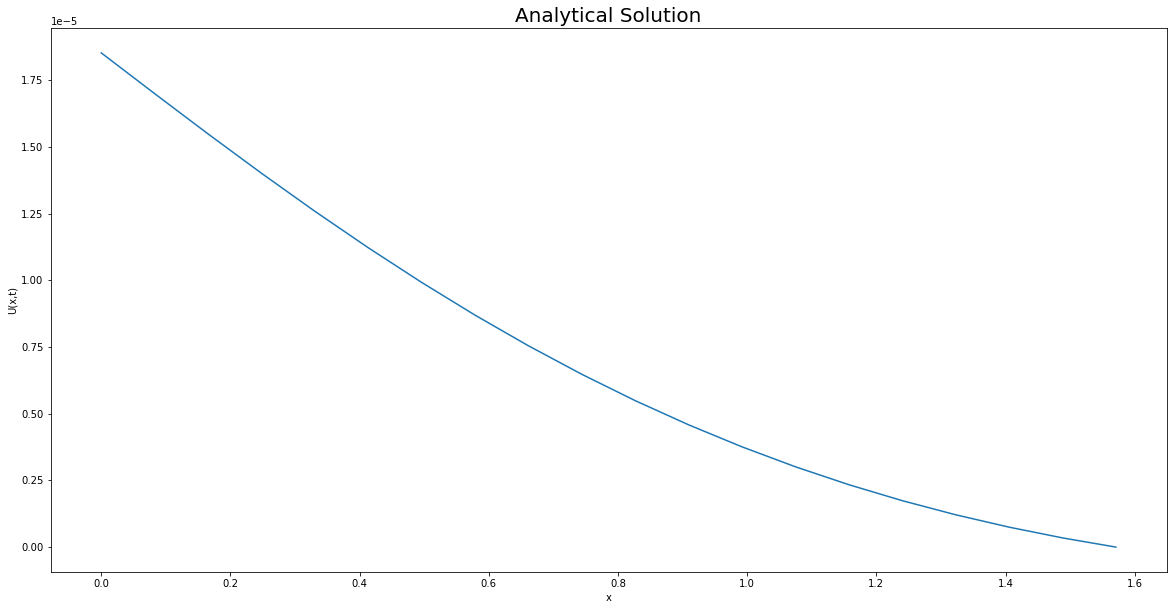

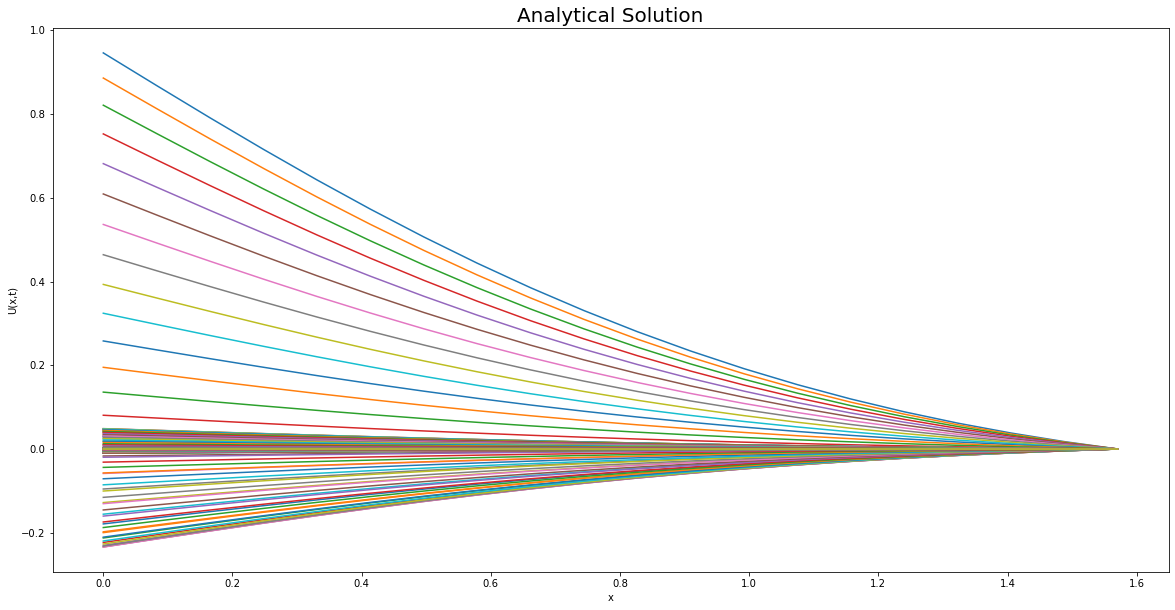

In [89]:
plot_analytic(N,T,K)

<a name = 'step4'></a>

## Явная схема крест

[К оглавлению](#content)

<a name = 'step4.1'></a>
### Теория

В варианте поставлена вторая начально-краевая задача для волнового уравнения. 
На введенной в случае уравнений параболлической природы пространственно-временной сетке аппроксимируем дифференциальное уравнение следующей схемой:

$$\frac{u_j^{k+1} - 2u_j^k + u_j^{k-1}}{\tau^2} = a^2\frac{u_{j+1}^k -2u_j^k + u_{j-1}^k}{h^2} + O(\tau^2+h^2), \hspace{0.5cm} j = \overline{1,N-1}$$

С шаблоном вида

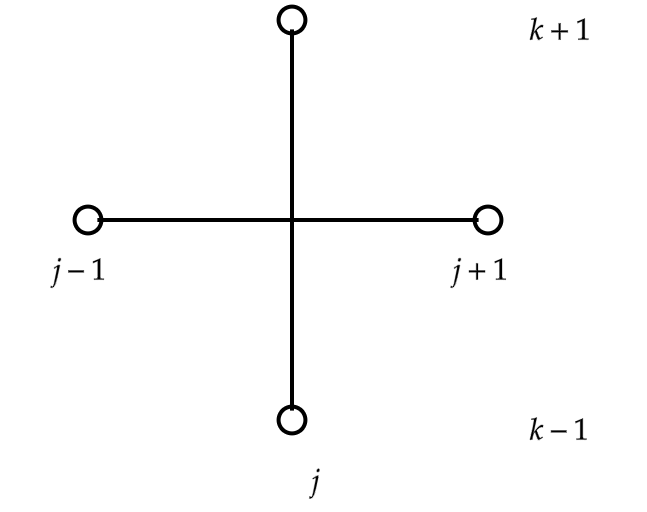


Явная конечно-разностная схема условно устойчива с условием $\sigma = \frac{a^2\tau^2}{h^2} < 1$. Это накладывает ограничения на сеточные характеристики.

Для определения $u_j^1$ можно воспользоваться аппроксимацией второго начального условия
$$\frac{u_j^1 - u_j^0}{\tau} = \psi_2(x_j) = \xi$$

Для повышения порядка аппроксимации воспользуемся разложением в ряд Тейлора на точном решении в окрестности $t = 0$ и подставим вместо второй производной исходным дифференциальным уравнением. В итоге, имеем

$$u_j^1 = \psi_1(x_j) +psi_2(x_j)\tau + a^2\psi''_1(x_j)\frac{\tau}{2}$$

<a name = 'step4.2'></a>

### Реализация

In [50]:
def explicit(N = 20, K = 200, T = 10, approx_f = 'so', a_ = 1, b_ = 2, c_ = -3, approx_type = None):
    space_step = (math.pi/2)/N
    time_step = T/K
    x = np.arange(0, math.pi/2 + space_step - 1e-4, space_step)#[0 + space_step*i for i in range(N)]
    t = np.arange(0, T + time_step - 1e-4, time_step)#[0 + time_step*i for i in range(K)]
    K = len(t)
    N = len(x)
    u = fill(space_step, N, K, a_, time_step, approx_f)
    sigma = a_**2 * time_step**2 / space_step**2
    d = 2
    T_ = []
    X = []
    X = [x, x]
    T_.append([0.0 for _ in x])
    T_.append([time_step for _ in x])
    for k in range(1, K-1):
        for j in range(1, N - 1):
            u[k + 1][j] = \
                u[k][j + 1] *(sigma + time_step**2*b_/(2*space_step))/(d*time_step/2+1) +\
                u[k][j] * (2 - 2*sigma + c_*time_step**2) /(d*time_step/2+1) + \
                u[k][j - 1] *(sigma - time_step**2*b_/(2*space_step))/(d*time_step/2+1) + \
                (u[k - 1][j] * (-1)*(1 - d*time_step/2))/(d*time_step/2+1)
        u[k+1][0] = f_1(None, time_step*k)
        u[k+1][-1] = f_2(None, time_step*k)
        X.append(x)
        T_.append([t[k] for _ in x])
    return u, X, T_

<a name = 'step4.3'></a>
### Исследования

In [51]:
u_fo = explicit(N, K, approx_f = 'fo')[0]
u_so = explicit(N, K, approx_f = 'so')[0]
u = [u_fo, u_so]

In [76]:
def plotTime(x, u, t, approx_f, method_name):
    fig = plt.figure(figsize=(20, 10))
    plt.xlabel('x', fontsize = 20)
    plt.ylabel('U(x,t)', fontsize = 20)
    plt.title(method_name + " scheme with " + approx_f, fontsize = 20)
    for j in range(2, len(u)):
        plt.plot(x, u[j])
    plt.show()
    #     fig = go.Figure()
#     fig.update_layout(title = "Solution with different time by" + approx_f,
#                       template = 'plotly_dark')
#     for j in range(2,len(u)):
#         fig.add_trace(go.Scatter(x = x, y = u[j], name = "t = " + str(round(t[j], 2))))
#     fig.show()
    #save_plot(fig)

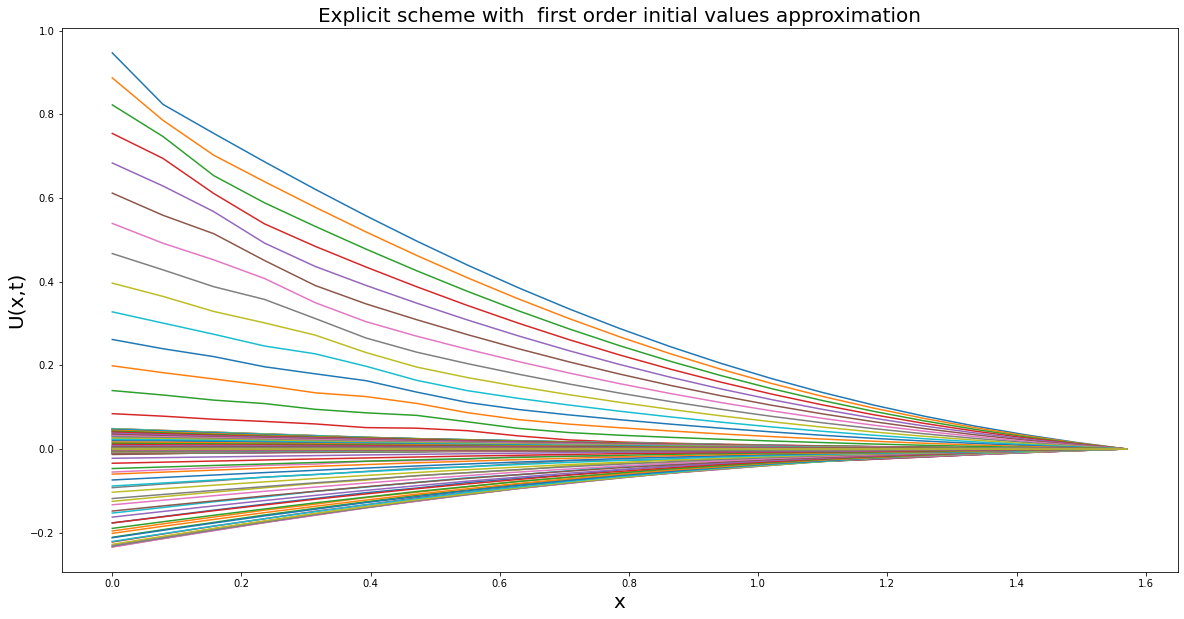

MSE =  1.4229756557503605e-08


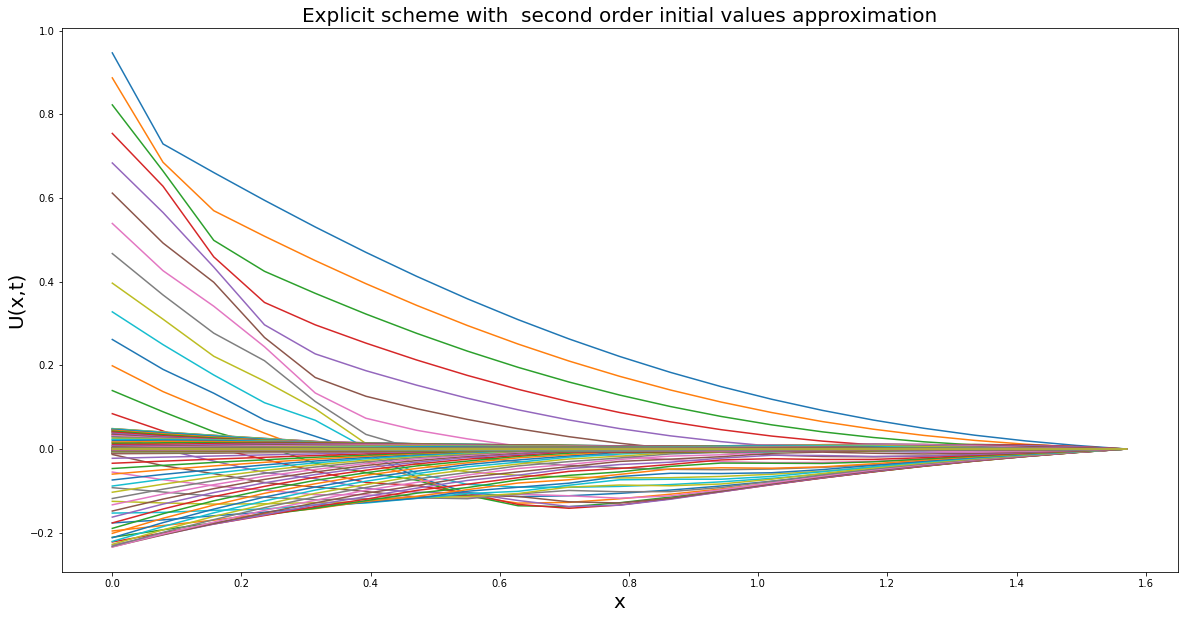

MSE =  2.580139647922956e-07


In [77]:
plotTime(x,u_fo,t, ' first order initial values approximation', 'Explicit')
print("MSE = ", MSE(x, t, u_fo))
plotTime(x,u_so,t, ' second order initial values approximation', 'Explicit')
print("MSE = ", MSE(x, t, u_so))

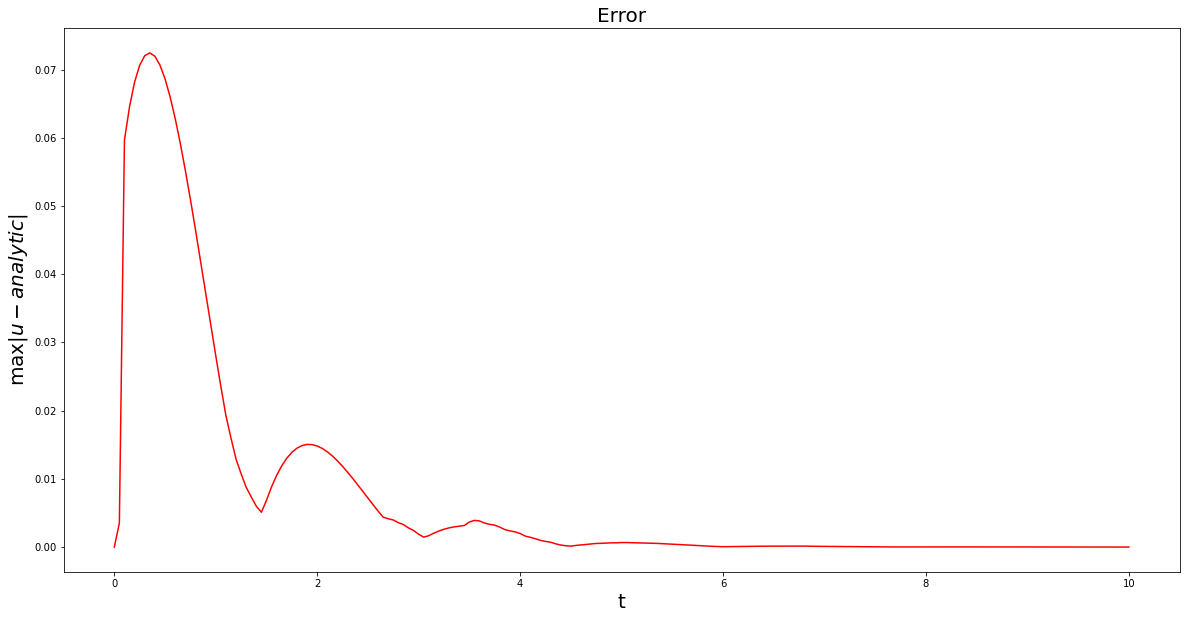

In [81]:
er = normm(x,t,u_fo)
fig = plt.figure(figsize=(20, 10))
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\max\left|u - analytic\right|$', fontsize = 20)
plt.title('Error', fontsize = 20)
plt.plot(t, er, color = 'red')
#plotly
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = t, y = er))
# fig_check_tmp.update_layout(title = "Error",
#                             xaxis_title = "t",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
#save_plot(fig_check_tmp)

In [56]:
def norm_error(x,t,u):
    ans = 0.0
    for i in range(len(u)):
        for j in range(len(u[i])):
            ans += (u[i][j] - analytic(x[i][j], t[i][j]))**2
    return ans/(len(u[0])*len(u))

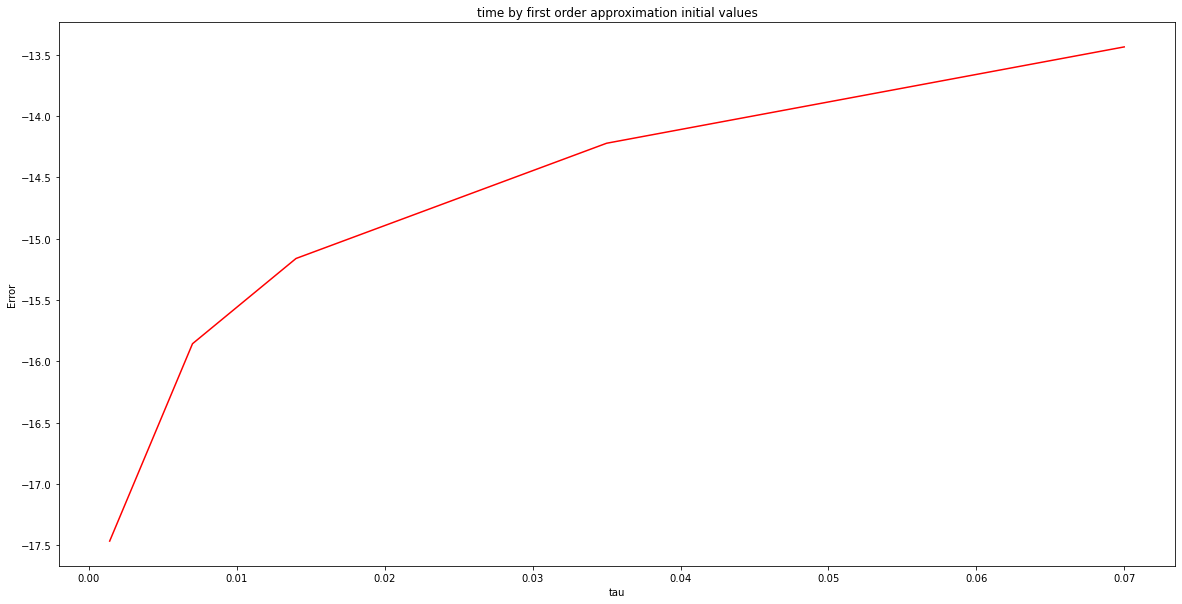

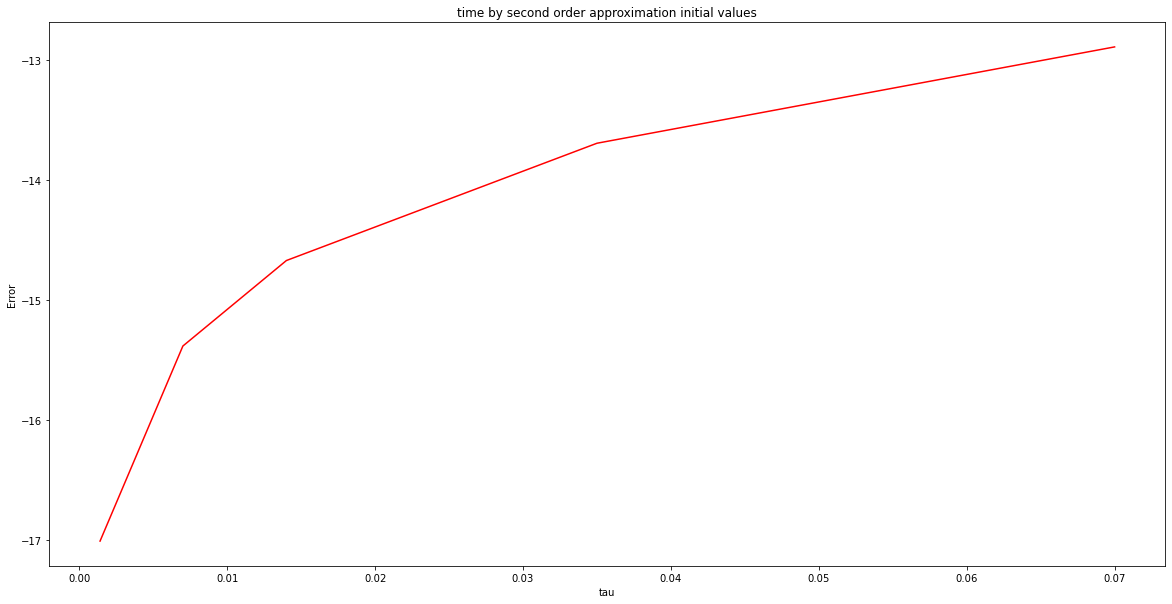

In [91]:
for approx_f in ['so', 'fo']:
    N_ = 10
    T_ = 7
    errors, taus = different_time_error(explicit, N_, T_, None, approx_f)
    plot_different_splits(errors, taus, 'time by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
                           " approximation initial values", "tau")
#     tmp_u, tmp_t = different_time(explicit, K, N, T, approx_f = approx_f)
#     plot_error(different_time_errors(tmp_u, K, N, T, x, t, len = 40), 'time by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
#                           " approximation initial values")
    #different_time(explicit,K,N,T,approx_f = 'fo',approx_type = None)

При увеличении количества разбиений по времени (уменьшении шага по времени) происходит следующий раскардаш: 
* В случае аппроксимации начальных условий первого и второго рода виден тренд на уменьшение ошибки с уменьшением шага по времени

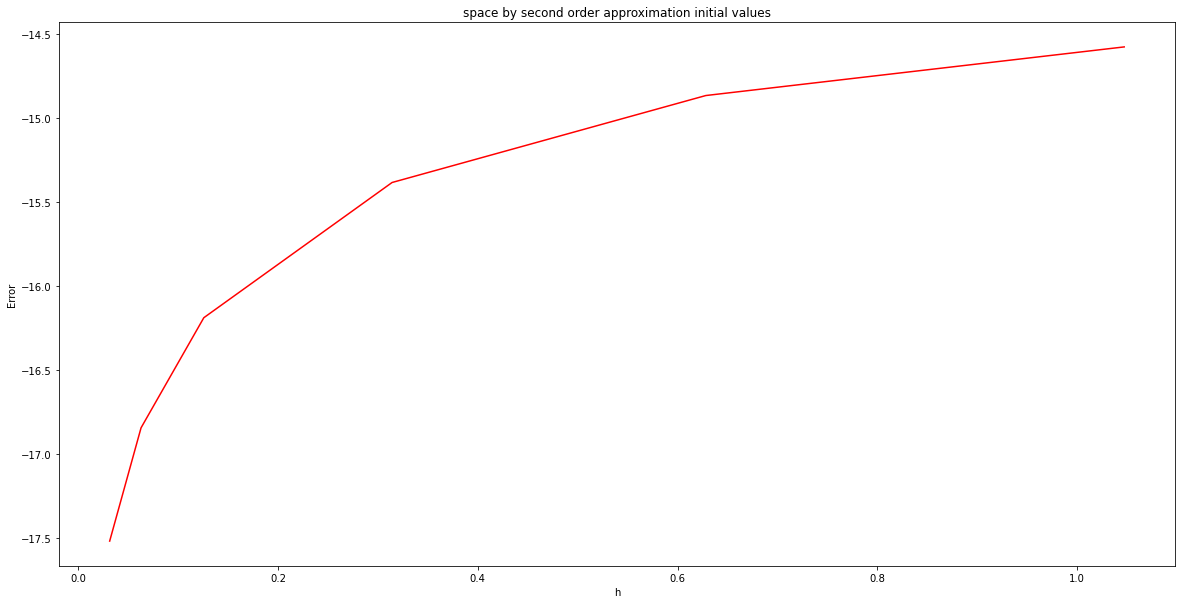

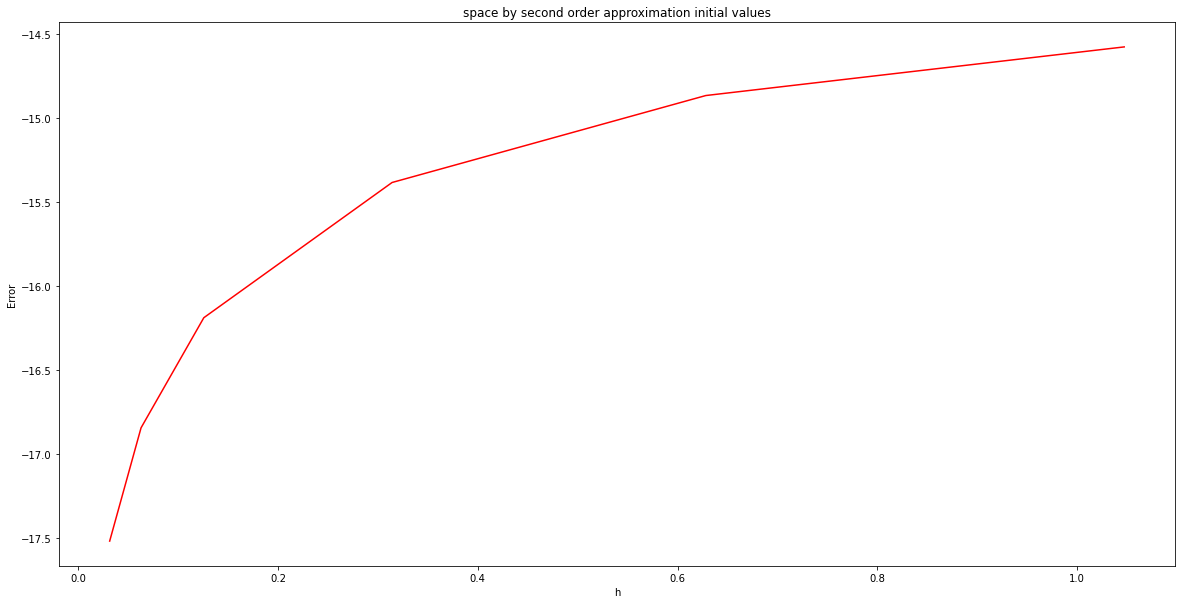

In [93]:
K_ = 1000
T_ = 7
approximations = ['so', 'fo']
for i in tqdm(range(len(approximations))):
  errors, hs = different_space_error(explicit, K_, T_, None, approx_f)
  plot_different_splits(errors, hs, 'space by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
                           " approximation initial values", 'h')

# errors = []
# for approx_f in ['so', 'fo']:
#     errors = []
#     tmp_u, tmp_h, tmp_x = different_h(explicit, K, N, T, approx_f = approx_f)
#     for u_,x_ in zip(tmp_u, tmp_x):
#         tmp = space_error(x_,u_,t)
#         errors.append(sum(tmp)/len(tmp))
#     #different_time(explicit,K,N,T,approx_f = 'fo',approx_type = None)
# fig_check = go.Figure()
# fig_check.add_trace(go.Scatter(x = tmp_h, y = errors))
# fig_check.update_layout(title = 'Errors with different space steps',
#                         xaxis_title = 'Space step',
#                         yaxis_title = 'Error',
#                         template = 'plotly_dark')
# fig_check.show()
# #save_plot(fig_check)

* В случае невыполнения условия стабильности $\frac{a^2\tau}{h^2}$ решение расходится. В обратном случае -- начинает сходиться.

* При уменьшении шага по пространству (увеличении количества разбиений по пространству) оба типа аппроксимации начальных условий уменьшаются (в случае  соблюдения условия стабильности)

In [95]:
construct_3d_plot(explicit, 'explicit')

Total error =  0.001543322005921124


<a name = 'step5'></a>

## Неявная

[К оглавлению](#content)

<a name = 'step5.1'></a>

### Теория

Неявная схема записывается в виде:

$$\frac{u_j^{k+1} - 2u_j^k + u_j^{k-1}}{\tau^2} = a^2\frac{u_{j+1}^{k+1} - 2u_j^{k+1} + u_{j-1}^{k+1}}{h^2} + O(\tau + h^2), \hspace{0.5cm} j = \overline{1,N-1}$$

Обладает абсолютной устойчивостью. Сводится к СЛАУ с трехдиагональной матрицей, решаемой методом прогонки. Аппроксимация начальных условий происходит тем же способом, что и в случае явной схемы.

Шаблон схемы

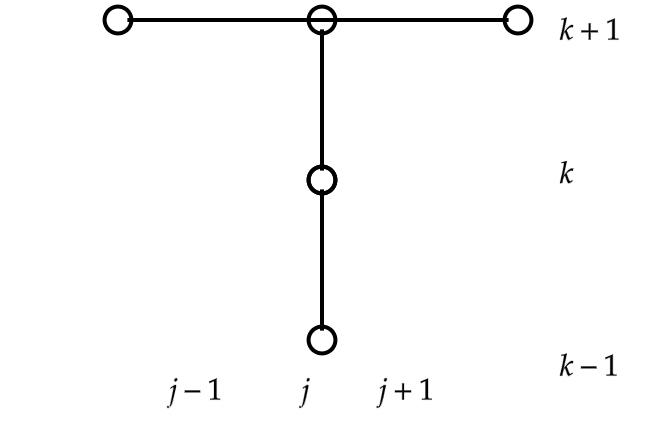

<a name = step5.2></a>

### Реализация

In [96]:
def tma(a,b,c,d,s):
    P = np.zeros(s)
    Q = np.zeros(s)

    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]

    k = s - 1

    for i in range(1, s):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[k] = 0
    Q[k] = (d[k] - a[k] * Q[k - 1]) / (b[k] + a[k] * P[k - 1])

    x = np.zeros(s)
    x[k] = Q[k]

    for i in range(s - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [111]:
def implicit(N = 20, K = 200, T = 10,x0 = 0, approx_f = 'so', approx_type = None, a_ = 1, b_ = 2, c_ = -3):
    space_step = (math.pi/2)/N
    time_step = T/K
    x = np.arange(0, math.pi/2 + space_step - 1e-4, space_step)#[0 + space_step*i for i in range(N)]
    t = np.arange(0, T + time_step - 1e-4, time_step)#[0 + time_step*i for i in range(K)]
    N = len(x)
    K = len(t)
    
    u = fill(space_step, N, K, a_, time_step, approx_f)
    sigma = a_**2 * time_step**2 / space_step**2
    X = []
    T_ = []
    X = [x, x]
    T_.append([0.0 for _ in x])
    T_.append([time_step for _ in x])
    alpha = 0
    beta = 1
    gamma = 0
    delta = 1
    tmp = b_*time_step**2/(2*space_step)
    d_ = 2
    for k in range(1, K - 1):
        a = np.zeros(N)
        b = np.zeros(N)
        c = np.zeros(N)
        d = np.zeros(N)

        for j in range(1, N - 1):
            a[j] = -sigma + tmp
            b[j] = (d_*time_step/2 + 1 + 2*sigma - c_*time_step**2)
            c[j] = -sigma - tmp
            d[j] = u[k - 1][j]*(d_*time_step/2 - 1) + 2*u[k][j]

        # граничные условия не содержат производных
        b[0] = beta - alpha / space_step
        c[0] = alpha / space_step
        d[0] = f_1(None, (k + 1) * time_step)

        a[-1] = - gamma / space_step
        b[-1] = delta + gamma / space_step
        d[-1] = f_2(None, (k + 1) * time_step)

        X.append(x)
        T_.append([t[k] for _ in x])
        Y = tma(a, b, c, d, N)
        u[k + 1] = Y
    return u, X, T_

<a name = 'step5.3'></a>

### Исследования

In [112]:
u_fo = implicit(N, K, x0=0, approx_f = 'fo')[0]
u_so = implicit(N, K, x0=0, approx_f = 'so')[0]
u = [u_fo, u_so]

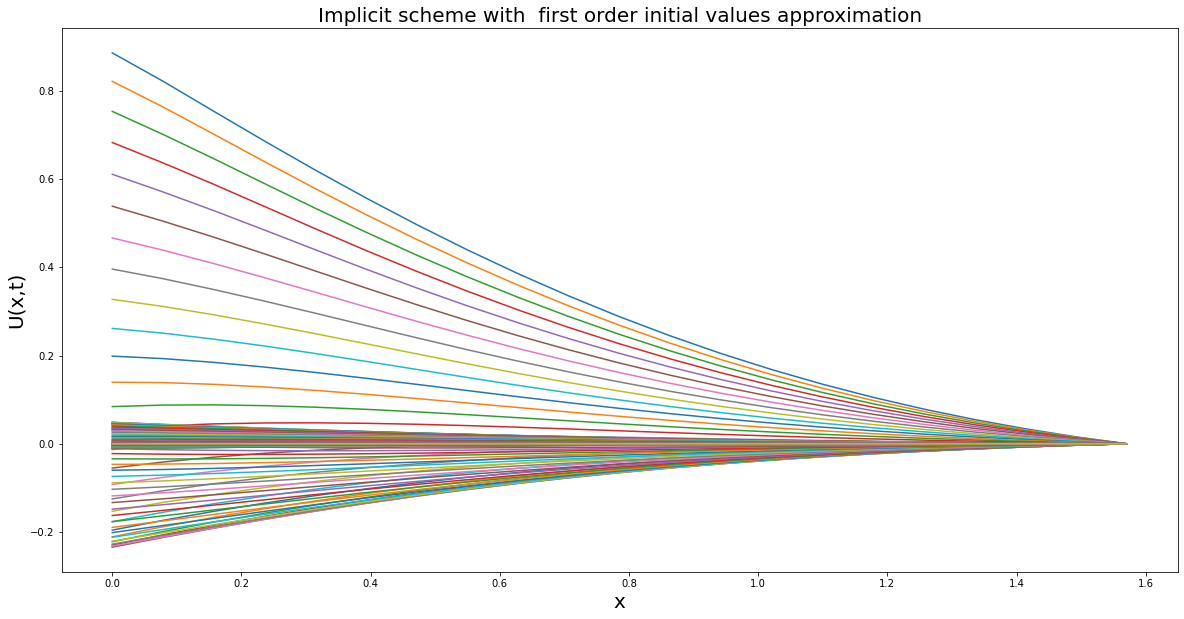

5.601601384676844e-09


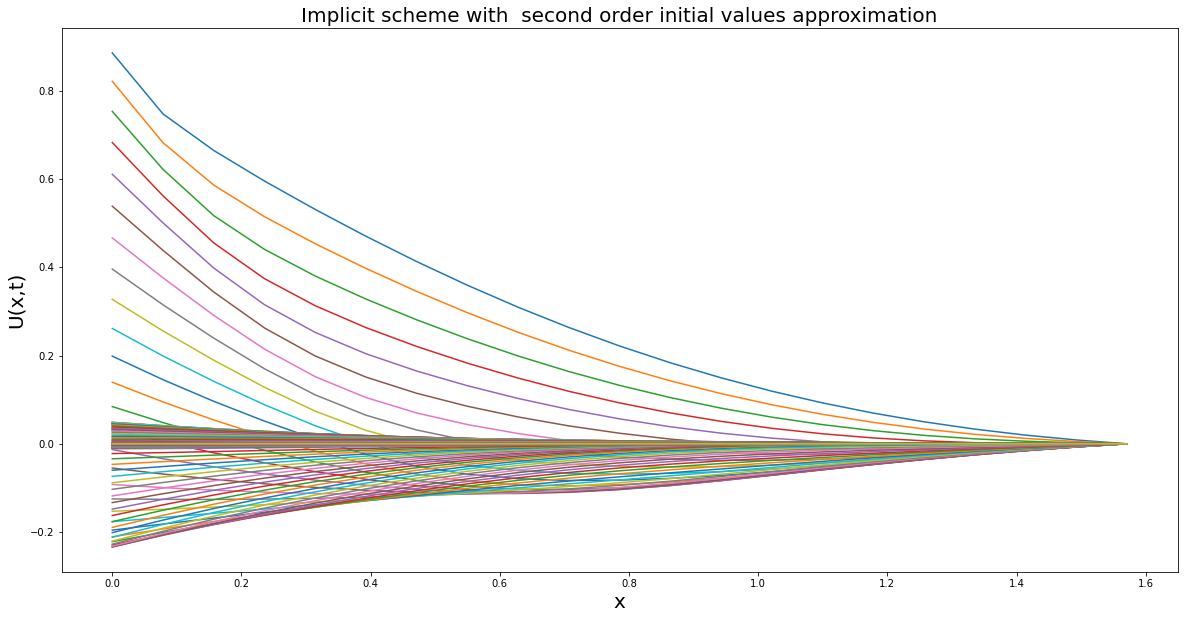

2.109201419323602e-07


In [113]:
plotTime(x,u_fo,t, ' first order initial values approximation', 'Implicit')
print(MSE(x, t, u_fo))
plotTime(x,u_so,t, ' second order initial values approximation', 'Implicit')
print(MSE(x, t, u_so))

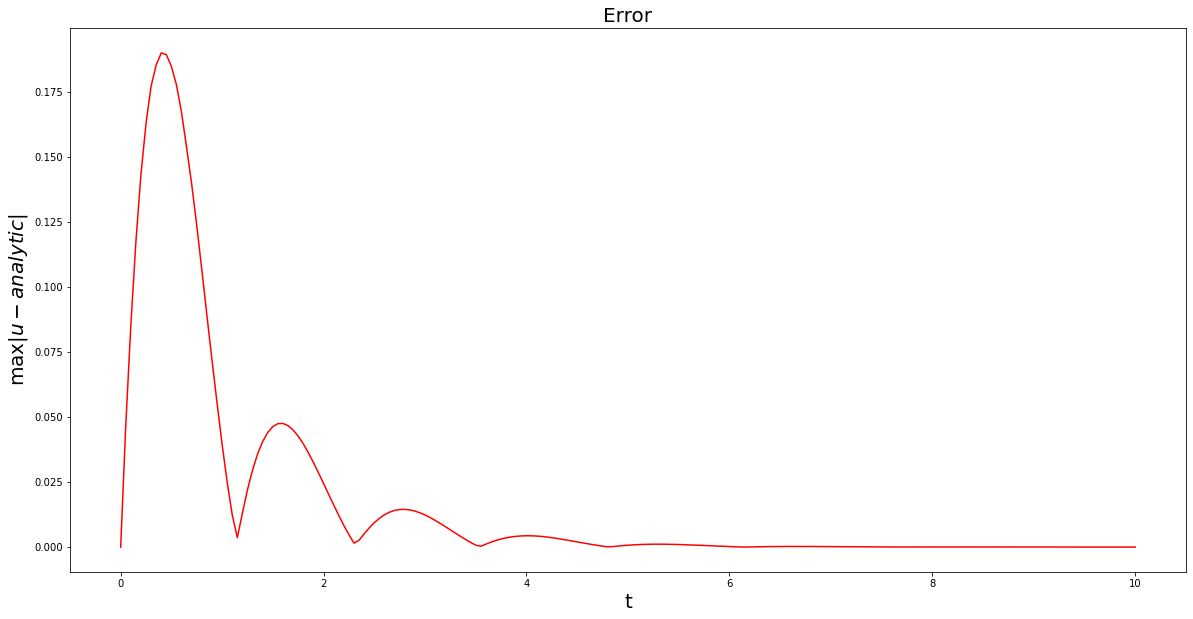

In [114]:
er = normm(x,t,u_so)
fig = plt.figure(figsize=(20, 10))
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\max\left|u - analytic\right|$', fontsize = 20)
plt.title('Error', fontsize = 20)
plt.plot(t, er, color = 'red')
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = t, y = er))
# fig_check_tmp.update_layout(title = "Error",
#                             xaxis_title = "t",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
#save_plot(fig_check_tmp)

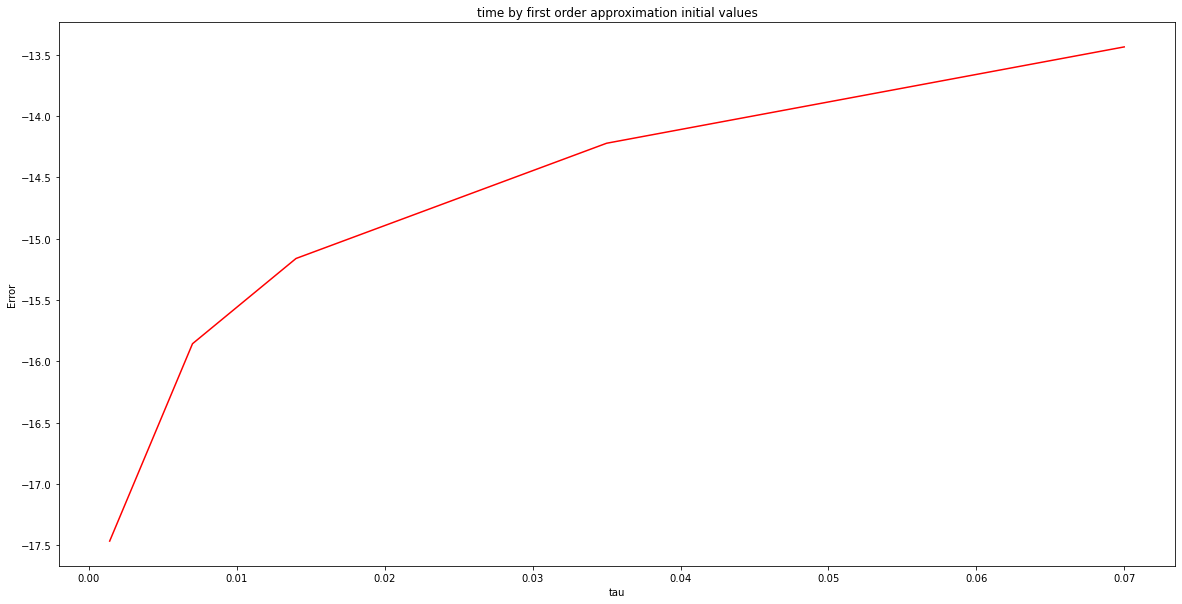

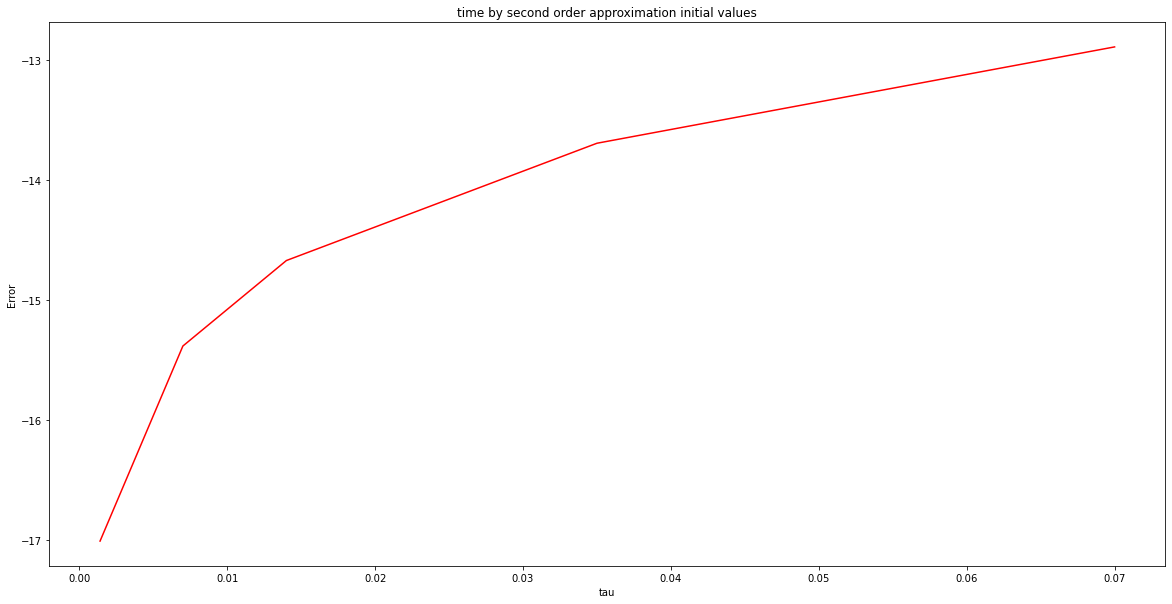

In [108]:
for approx_f in ['so', 'fo']:
    N_ = 10
    T_ = 7
    errors, taus = different_time_error(explicit, N_, T_, None, approx_f)
    plot_different_splits(errors, taus, 'time by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
                           " approximation initial values", "tau")
#     tmp_u, tmp_t = different_time(explicit, K, N, T, approx_f = approx_f)
#     plot_error(different_time_errors(tmp_u, K, N, T, x, t, len = 40), 'time by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
#                           " approximation initial values")
    #different_time(explicit,K,N,T,approx_f = 'fo',approx_type = None)

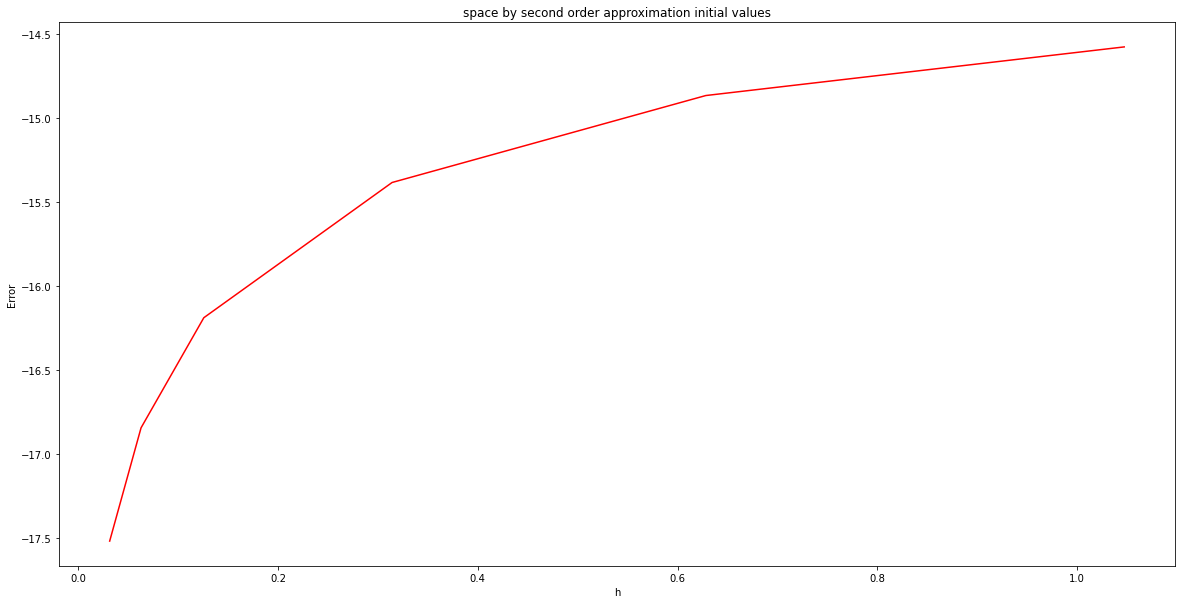

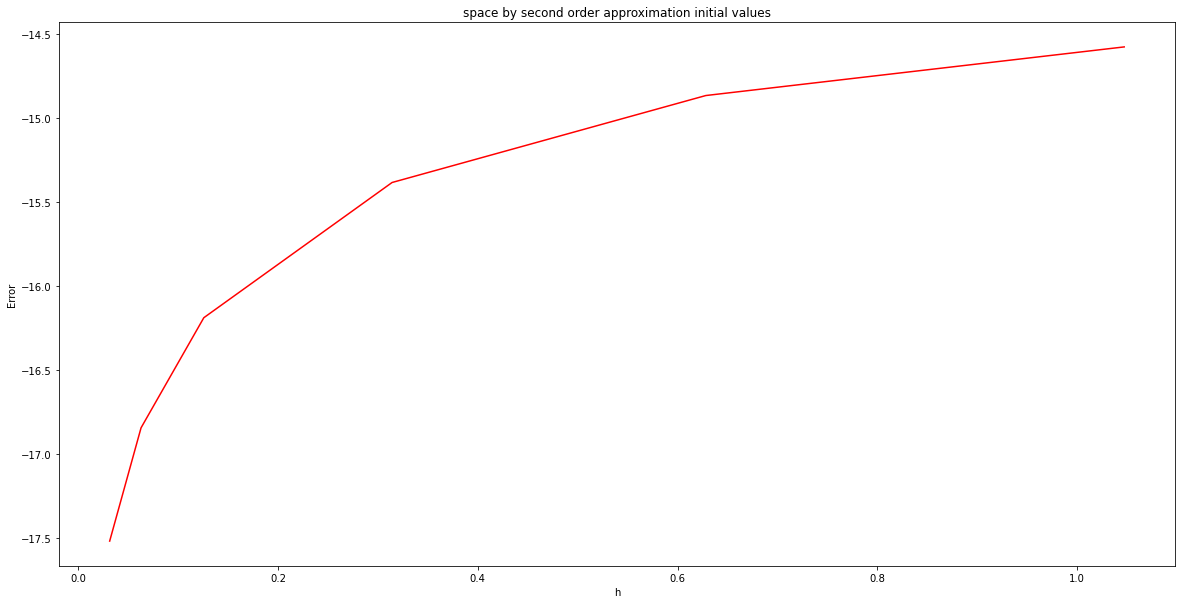

In [109]:
K_ = 1000
T_ = 7
approximations = ['so', 'fo']
for i in tqdm(range(len(approximations))):
  errors, hs = different_space_error(explicit, K_, T_, None, approx_f)
  plot_different_splits(errors, hs, 'space by ' + ("second order" if approx_f[0] == 'f' else "first order") +\
                           " approximation initial values", 'h')

# errors = []
# for approx_f in ['so', 'fo']:
#     errors = []
#     tmp_u, tmp_h, tmp_x = different_h(explicit, K, N, T, approx_f = approx_f)
#     for u_,x_ in zip(tmp_u, tmp_x):
#         tmp = space_error(x_,u_,t)
#         errors.append(sum(tmp)/len(tmp))
#     #different_time(explicit,K,N,T,approx_f = 'fo',approx_type = None)
# fig_check = go.Figure()
# fig_check.add_trace(go.Scatter(x = tmp_h, y = errors))
# fig_check.update_layout(title = 'Errors with different space steps',
#                         xaxis_title = 'Space step',
#                         yaxis_title = 'Error',
#                         template = 'plotly_dark')
# fig_check.show()
# #save_plot(fig_check)

In [116]:
construct_3d_plot(implicit, 'Implicit')

Total error =  0.001387656574808032
